# Bitcoin price prediction

# RafaCastle

## Main objective of the analysis

The dataset for this analysis is taken from from [cryptodatadownload](https://www.cryptodatadownload.com/data/binance/) and contains Bitcoin prices registred by Binance between 2019 and 2021. We'll employ a Recurrent Neural Network (RNN), Long Short-Term Memory (LSTM) and ... to predict the bitcoin price.

## Description of the data set

In the dataset we have the following attributes:

- Unix Timestamp: This is the unix timestamp or also known as "Epoch Time". Use this to convert to your local timezone
- Date: This timestamp is UTC Timezone
- Symbol: The symbol for which the timeseries data refers
- Open: This is the opening price of the time period
- High: This is the highest price of the time period
- Low: This is the lowest price of the time period
- Close: This is the closing price of the time period
- Volume (Crypto): This is the volume in the transacted Ccy. Ie. For BTC/USDT, this is in BTC amount
- Volume Base Ccy: This is the volume in the base/converted ccy. Ie. For BTC/USDT, this is in USDT amount
- Trade Count: This is the unique number of trades for the given time period

The timestep width in this dataset is of one day, so the close attribute is the bitcoin price at 11:59 pm, that's the variable we're going to predict.

## Data exploration

First let's import the libraries

In [1]:
# basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import warnings
warnings.simplefilter(action='ignore')
from datetime import datetime
import math

# machine learning libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Activation, Dropout

Importing the dataset

In [12]:
data = pd.read_csv('BTCUSDT_Binance_futures_data_day.csv',sep=",")
data.head()

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USDT,tradecount
0,1.639010e+12,09/12/2021 00:00,BTC/USDT,50459.61,50773.00,50420.00,50706.83,2429.765,1.230507e+08,28223
1,1.638920e+12,08/12/2021 00:00,BTC/USDT,50577.20,51210.60,48533.33,50455.61,238229.884,1.192755e+10,2569992
2,1.638840e+12,07/12/2021 00:00,BTC/USDT,50424.72,51929.00,50012.00,50577.20,224670.618,1.145537e+10,2571721
3,1.638750e+12,06/12/2021 00:00,BTC/USDT,49373.83,50888.00,47000.00,50424.72,357711.029,1.741656e+10,3868686
4,1.638660e+12,05/12/2021 00:00,BTC/USDT,49135.66,49699.49,47755.00,49376.60,286434.382,1.401602e+10,3163309


## Data cleaning

Let's take just the date in a dd/mm/yyyy format 

In [13]:
for i in range(len(data)):
    data["date"][i]=data["date"][i][:10]
data.head()

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USDT,tradecount
0,1.639010e+12,09/12/2021,BTC/USDT,50459.61,50773.00,50420.00,50706.83,2429.765,1.230507e+08,28223
1,1.638920e+12,08/12/2021,BTC/USDT,50577.20,51210.60,48533.33,50455.61,238229.884,1.192755e+10,2569992
2,1.638840e+12,07/12/2021,BTC/USDT,50424.72,51929.00,50012.00,50577.20,224670.618,1.145537e+10,2571721
3,1.638750e+12,06/12/2021,BTC/USDT,49373.83,50888.00,47000.00,50424.72,357711.029,1.741656e+10,3868686
4,1.638660e+12,05/12/2021,BTC/USDT,49135.66,49699.49,47755.00,49376.60,286434.382,1.401602e+10,3163309


Now lets take the year, month and day

In [14]:
def make_date(row):
    return datetime(year = int(row.split('/')[2]), 
                    month = int(row.split('/')[1]), 
                    day = int(row.split('/')[0]))

In [15]:
data['date'] = data['date'].apply(make_date)
data.set_index(data.date,inplace=True)
data.drop(columns=['date'], inplace=True)

## Data exploration

This is how the bitcoin price has changed until now (9/12/2021), the plot shows the highest price (orange) and the closing and opening prices (blue and green)

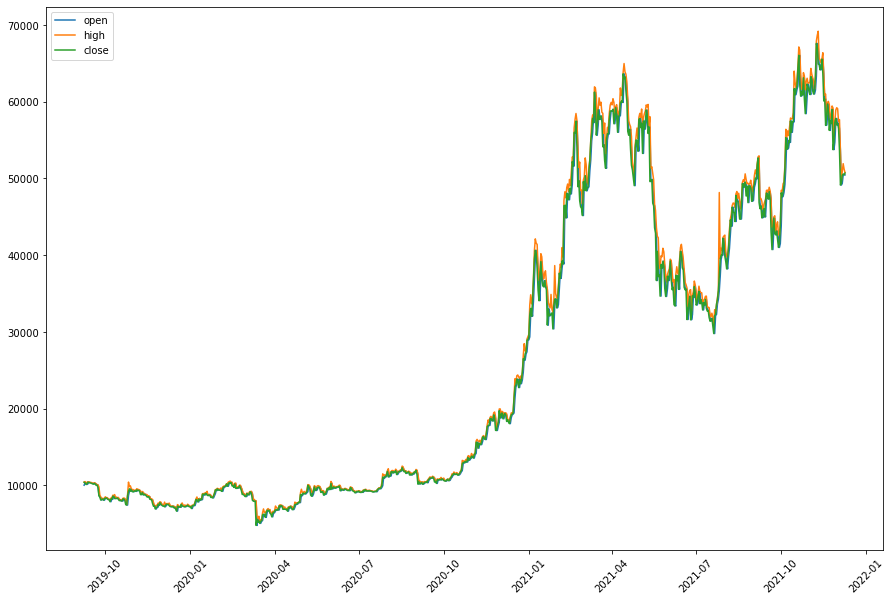

In [16]:
plt.figure(figsize=(15,10))
plt.plot(data[["open"]],label="open");
plt.plot(data[["high"]],label="high");
plt.plot(data[["close"]],label="close");
plt.legend();
plt.xticks(rotation=45);

Now let's see how does the number of trades have changed

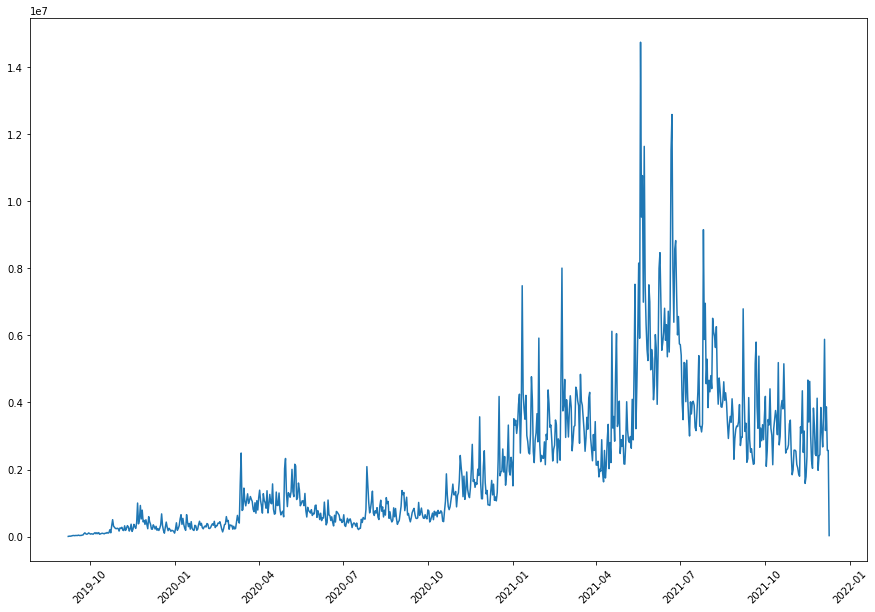

In [7]:
plt.figure(figsize=(15,10))
plt.plot(data[["tradecount"]]);
plt.xticks(rotation=45);

We can also llok at the ratio between the closing and the opening prices, it oscilates between 1 because the btc price is almost the same in a 1-day variation, when it is grater than 1 it means that the closing price was bigger.

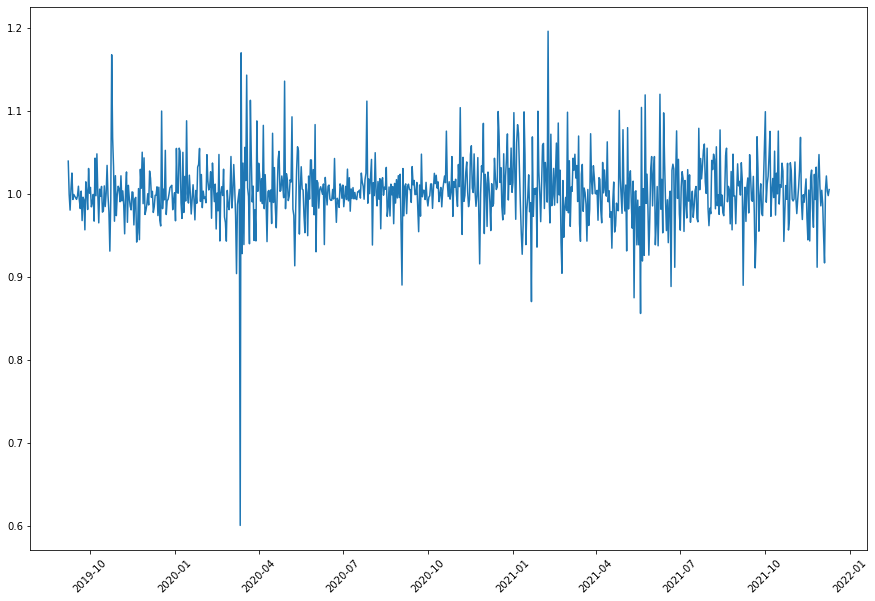

In [8]:
plt.figure(figsize=(15,10))
plt.plot(data["close"]/data["open"]);
plt.xticks(rotation=45);

## Feature engineering

Now we are going to transform the **date** column into a datetime object, split the data  into train and testing sets and scale it with **MinMaxScaler**

In [17]:
timesteps = 50 # 50 days 
data=data[["close"]] # we'll predict just the closing price

#spliting
train = data[:len(data)-timesteps]['close'].values # we'll predict the last 50 days
test = data[len(train):]['close'].values
train=train.reshape(train.shape[0],1)
test=test.reshape(test.shape[0],1)

#scaling
sc = MinMaxScaler(feature_range= (0,1))
train = sc.fit_transform(train)

#training set
train_X = []
train_y = []
for i in range(timesteps, train.shape[0]):
    train_X.append(train[i-timesteps:i,0])
    train_y.append(train[i,0])
train_X = np.array(train_X)
train_X = train_X.reshape(train_X.shape[0], train_X.shape[1], 1)
train_y = np.array(train_y)

#inputs
inputs = data[len(data) - len(test) - timesteps:]
inputs = sc.transform(inputs)

# testing set
test_X = []
for i in range(timesteps, 100):
    test_X.append(inputs[i-timesteps:i,0])
test_X = np.array(test_X)
test_X = test_X.reshape(test_X.shape[0], test_X.shape[1], 1)

## Model 1: RNN

We'll use **RNN** layers, each with 50 hidden units and tanh activation function per cell, we're going to fit the model with 100 epochs.

In [10]:
model = Sequential() 

model.add(SimpleRNN(50, activation='tanh',
                    input_shape=(train_X.shape[1],1), return_sequences = True))
model.add(Dropout(0.2))
model.add(SimpleRNN(50, activation='tanh', return_sequences = True,))
model.add(Dropout(0.2))
model.add(SimpleRNN(50, activation='tanh', return_sequences = True,))
model.add(Dropout(0.2))
model.add(SimpleRNN(50, activation='tanh'))
model.add(Dense(1))

#loss function
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(train_X, train_y, epochs=100, batch_size=32, verbose=0)

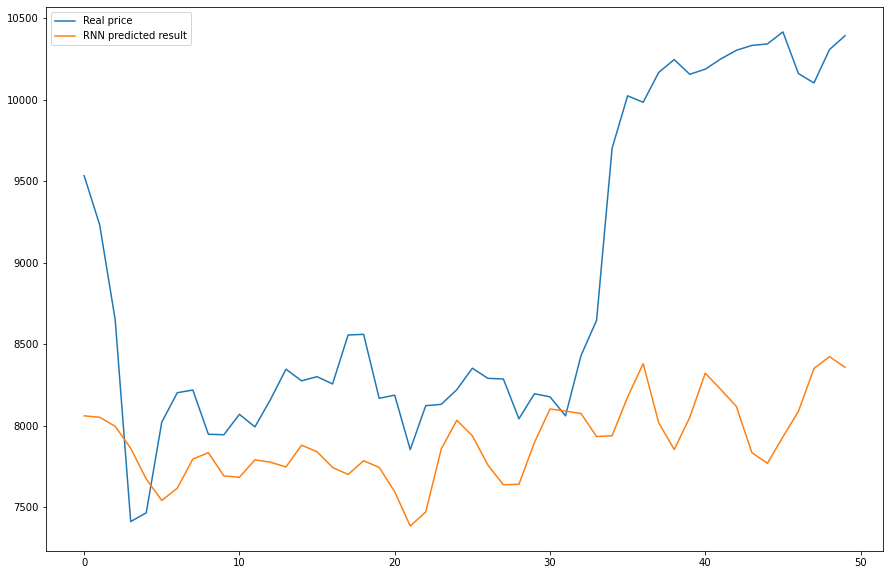

In [11]:
predicted = model.predict(test_X)
predicted = sc.inverse_transform(predicted)

plt.figure(figsize=(15,10))
plt.plot(test,label="Real price")
plt.plot(predicted,label="RNN predictions")
plt.legend()
plt.show()

The prediction didn't see the bull market that started in day 30.

## Model 2: LSTM

Now we'll use **LSTM** with 70 hidden units per cell and with 100 epochs

In [18]:
model2 = Sequential() 
model2.add(LSTM(70, input_shape=(train_X.shape[1],1)))
model2.add(Dense(1))

model2.compile(loss='mean_squared_error', optimizer='adam')
model2.fit(train_X, train_y, epochs=100, batch_size=32, verbose=0)

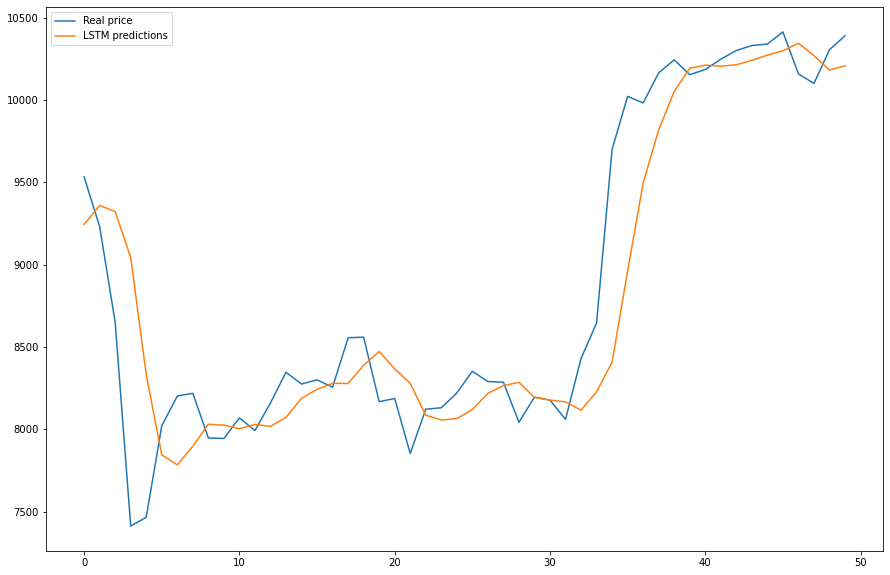

In [20]:
predicted2 = model2.predict(test_X)
predicted2 = sc.inverse_transform(predicted2)

plt.figure(figsize=(15,10))
plt.plot(test,label="Real price")
plt.plot(predicted2,label="LSTM predictions")
plt.legend()
plt.show()

The prediction was able to see the bull market that started in day 30! and was more accurate in it's predictions.

## Model 3: Trying to improve RNN

We are going to repeat model 1 changing the units and the batch size.

In [35]:
model3 = Sequential() 

model3.add(SimpleRNN(70, activation='tanh',
                    input_shape=(train_X.shape[1],1), return_sequences = True))
model3.add(Dropout(0.2))
model3.add(SimpleRNN(70, activation='tanh', return_sequences = True,))
model3.add(Dropout(0.2))
model3.add(SimpleRNN(70, activation='tanh', return_sequences = True,))
model3.add(Dropout(0.2))
model3.add(SimpleRNN(70, activation='tanh'))
model3.add(Dense(1))

#loss function
model3.compile(loss='mean_squared_error', optimizer='adamax') 
model3.fit(train_X, train_y, epochs=100, batch_size=64, verbose=0)

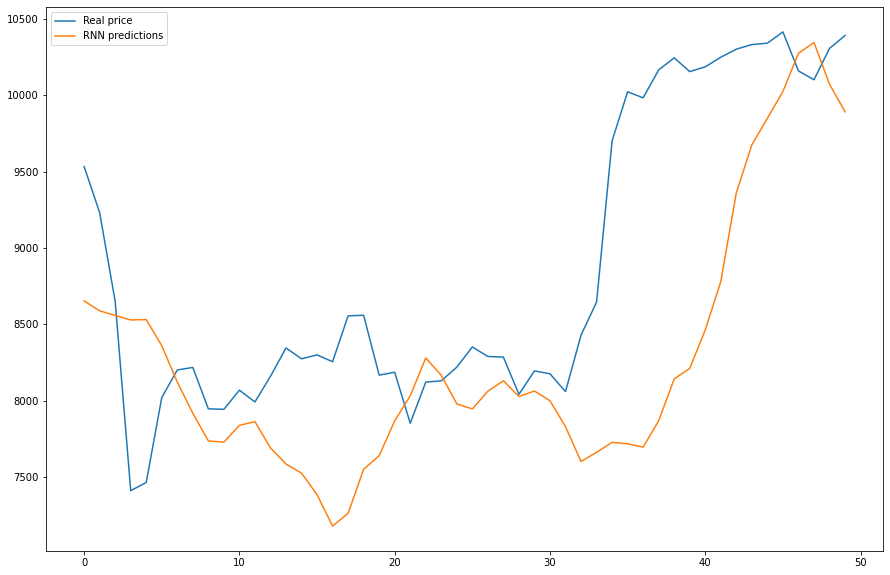

In [36]:
predicted3 = model3.predict(test_X)
predicted3 = sc.inverse_transform(predicted3)

plt.figure(figsize=(15,10))
plt.plot(test,label="Real price")
plt.plot(predicted3,label="RNN predictions")
plt.legend()
plt.show()

Now the model actually predicts the bear maket but with 10 days of delay, we accomplished to improve model one but model 2 is still having more accuarate predictions.

## Summary and best model

By comparing the first **RNN** model with the **LSTM** model in the next cells, we can see that there are more trainable parameters for the **LSTM**, which explains why it took a longer time to train this model, however, the second **RNN** model has even more trainable parameters and it doesn't predict bitcoin price as well.

Overall the plots show that our **LSTM** model with a far less complex structure performed better than both RNN models.

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50, 50)            2600      
                                                                 
 dropout (Dropout)           (None, 50, 50)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 50, 50)            5050      
                                                                 
 dropout_1 (Dropout)         (None, 50, 50)            0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 50, 50)            5050      
                                                                 
 dropout_2 (Dropout)         (None, 50, 50)            0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 50)                5

In [40]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 70)                20160     
                                                                 
 dense_1 (Dense)             (None, 1)                 71        
                                                                 
Total params: 20,231
Trainable params: 20,231
Non-trainable params: 0
_________________________________________________________________


In [41]:
model3.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_32 (SimpleRNN)   (None, 50, 70)            5040      
                                                                 
 dropout_24 (Dropout)        (None, 50, 70)            0         
                                                                 
 simple_rnn_33 (SimpleRNN)   (None, 50, 70)            9870      
                                                                 
 dropout_25 (Dropout)        (None, 50, 70)            0         
                                                                 
 simple_rnn_34 (SimpleRNN)   (None, 50, 70)            9870      
                                                                 
 dropout_26 (Dropout)        (None, 50, 70)            0         
                                                                 
 simple_rnn_35 (SimpleRNN)   (None, 70)               

# Next Steps

To improve the quality of forecasts over many time steps, we'd need to use more data, for example the bitcoin history with a minute or hour step width, also we would need a more sophisticated LSTM model structur. Also we could see the correlation between the volume and the btc price for a more accuarate analysis.